In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astroML.correlation import bootstrap_two_point_angular, two_point_angular

In [2]:
from lognormal_counts_yunting import *

In [3]:
from hmf import MassFunction
mass_function = MassFunction(z=0., dlog10m=0.02)

In [47]:
def generate_positions(Nsrc, size, nmaps, ell_min=90., random_positions=False, cl=None, ells=None):
    
    if random_positions:
        txs = np.random.uniform(0, size, (nmaps, Nsrc))
        tys = np.random.uniform(0, size, (nmaps, Nsrc))

    else:
        txs, tys = [], []
        print(size)
        # draw galaxy positions from GRF with given power spectrum, number_counts in deg**-2
        counts, grfs = generate_count_map_2d(nmaps, cl=cl, size=size, 
                                             ell_min=ell_min, Ntot=Nsrc, ell_sampled=ells)

        # uncomment these lines to look at the density fields generated
#         for i in range(counts.shape[0]):
#             plt.figure()
#             plt.imshow(grfs[i])
#             plt.colorbar()
#             plt.show()
        
        for i in range(counts.shape[0]):
            tx, ty = positions_from_counts(counts[i])
            txs.append(tx)
            tys.append(ty)

    return txs, tys

def make_galaxy_cts_map(cat, refmap_shape, normalize=True):
    # this function is for visualizing the galaxy counts map
    gal_map = np.zeros(shape=refmap_shape)

    cat = np.array([src for src in cat if src[0]<refmap_shape[0] and src[1]<refmap_shape[1]])
   
    for src in cat:
        gal_map[int(src[0]),int(src[1])] +=1.

    if normalize:
        gal_map /= np.mean(gal_map)
        gal_map -= 1.
    
    return gal_map

def generate_galaxy_clustering(number_counts, size=1024, \
                               # number counts should be an array corresponding to the desired redshift bins
                               zmin=0.01, zmax=1.0, ng_bins=3, \
                               # set redshift range 
                               n_square_deg=4.0, n_catalog=1, \
                               # set FOV in square degrees and number of clustering realizations
                               random_positions=False, \
                               # set to True if you want just shot noise
                               cl = None, \
                                # leave this as None and the function will compute C_ell from the halo model
                                ell_min=90.):
                              # size is just the side length of the simulated image, but 
    
    zrange_grf = np.linspace(zmin, zmax, ng_bins+1) # ng_bins+1 since we take midpoints
    midzs = 0.5*(zrange_grf[:-1]+zrange_grf[1:])
    dzs = zrange_grf[1:]-zrange_grf[:-1] 
    thetax_list = [[] for x in range(n_catalog)]
    thetay_list = [[] for x in range(n_catalog)]

    for i, z in enumerate(midzs):

        if cl is None:
            # ell_min and ell_max don't need to be the exact range of the FOV, just need to cover the range
            # the limber project ell_min/ell_max are separate from the one used to generate positions
            ells, cl = limber_project(mass_function, zrange_grf[i], zrange_grf[i+1],
                                      ell_min=22.5, ell_max=3e5)
        txs, tys = generate_positions(number_counts[i]*n_square_deg, size, n_catalog, \
                                         ell_min=ell_min, random_positions=random_positions, \
                                        cl=cl, ells=ells)

        for cat in range(n_catalog):
            thetax_list[cat].extend(txs[cat])
            thetay_list[cat].extend(tys[cat])
            
    return thetax_list, thetay_list

def get_angular_2pt_func(cat_celestial, bins, nboot=1):

    print(cat_celestial.shape)
    if nboot==1:
        print('No bootstrapping')
        corr = two_point_angular(cat_celestial[:,0], cat_celestial[:,1], bins)
        return corr, [], []
    else:
        corr, dcorr, boot = bootstrap_two_point_angular(cat_celestial[:,0], 
                                                        cat_celestial[:,1], bins, 
                                                        method='landy-szalay', Nbootstraps=nboot)
        return corr, dcorr, boot

def linear_ang2pt(thetas, theta0=0.01666, A=0.8):
    return A*(thetas/theta0)**(-0.8)

In [48]:
ng_bins=1 # this is the number of redshift bins you want, if you want to generate several GRFs and superpose them
zmin=0.01
zmax=1.0
n_catalog = 3
number_counts = [500] # you want this to be in counts per square degree, since it gets multiplied by n_square_deg 
                        # in the function below. you might get a values from the helgason model
size = 1024 # side length of image to place counts in 
n_square_deg = 64.0

In [49]:
# generate the clustering catalog. check the defaults to 
#make sure they are what you want, especially with ell_min and the like.

tx, ty = generate_galaxy_clustering(number_counts, size=size, 
                                    ell_min=22.5, n_square_deg=n_square_deg, 
                                    n_catalog=n_catalog, ng_bins=ng_bins)

1024


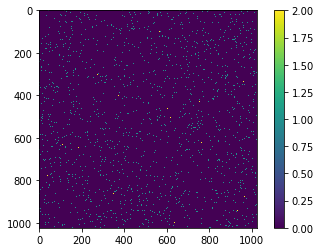

7.9921875
(31795, 2)
No bootstrapping


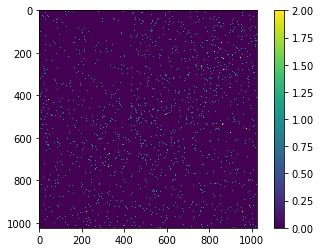

7.9921875
(31229, 2)
No bootstrapping


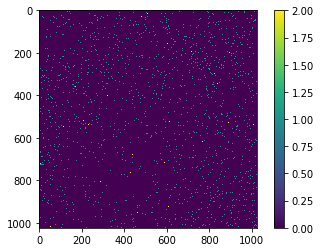

7.9921875
(30511, 2)
No bootstrapping


In [50]:
bins = 3*10**(np.linspace(-3, 1, 20)) # radians

corrs, dcorrs = [], []

for i in range(n_catalog):
    
    cat = np.array([tx[i], ty[i]]).transpose()
    
    # can use this for visualization sanity check that counts make sense
    gmap_unnormalized = make_galaxy_cts_map(cat, [size, size], normalize=False)

    plt.figure()
    plt.imshow(gmap_unnormalized, vmax=2)
    plt.colorbar()
    plt.show()
    
    ''' The galaxy catalogs obtained above are going to be in the pixel units, so we should convert these 
    to approximate celestial coordinates 
    (since we invoked the flat sky approximation in generating the clustering)
    The zero point shouldn't matter for computing the 2pt correlation function
    '''
    cat_celestial = np.array(cat)*(np.sqrt(n_square_deg)/size)
    
    # max value should roughly be the number of degrees across FOV
    print(np.max(cat_celestial))
    
    corr, dcorr, _ = get_angular_2pt_func(cat_celestial, bins, nboot=1)
    
    corrs.append(corr)
    dcorrs.append(dcorr)
    
   

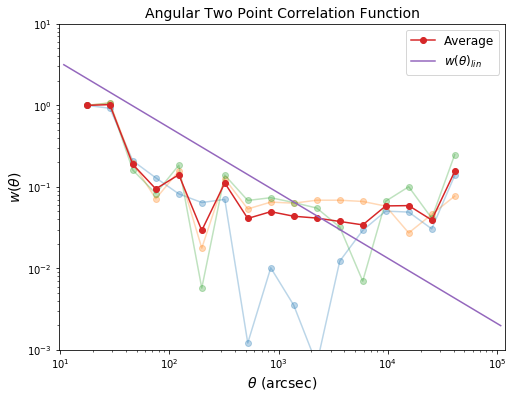

In [51]:
deg_to_arcsec = 3600

plt.figure(figsize=(8, 6))
plt.title('Angular Two Point Correlation Function', fontsize=14)
for i in range(n_catalog):
    if dcorrs[i] == []:
        # taking the absolute value of the correlation function in these lines
        # but not sure if thats the right thing to do
        plt.plot(bins[1:]*deg_to_arcsec, np.abs(corrs[i]), marker='o', alpha=0.3)
    else:
        plt.errorbar(bins[1:]*deg_to_arcsec, np.abs(corrs[i]), yerr=dcorrs[i], marker='o')

plt.plot(bins[1:]*deg_to_arcsec, np.mean(np.abs(corrs), axis=0), marker='o', label='Average')
plt.plot(bins*deg_to_arcsec, linear_ang2pt(bins), label='$w(\\theta)_{lin}$')    
plt.legend(fontsize='large')
plt.xscale('log')
plt.xlim(0.9*np.min(bins)*deg_to_arcsec, 1.1*np.max(bins)*deg_to_arcsec)
plt.yscale('log')
plt.ylim(1e-3, 1e1)
plt.xlabel('$\\theta$ (arcsec)', fontsize=14)
plt.ylabel('$w(\\theta)$', fontsize=14)
plt.show()